# GAN Concept Demo: Building Blocks of Deepfake Generators

This notebook demonstrates the core components of a Generative Adversarial Network (GAN).  
We define a simple Generator and Discriminator using PyTorch, show the training loop logic, and visualize how adversarial learning works — even if we don't fully train it here.

> 💡 This prepares us for building a real DCGAN in the next step.

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Define the Generator

The Generator learns to map from a random noise vector (z) to a synthetic image.

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, hidden_dim=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: z (batch_size, z_dim)
            nn.Linear(z_dim, hidden_dim * 4 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dim * 4, 4, 4)),

            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),

            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# Initialize
generator = Generator().to(device)

## 2. Define the Discriminator

The Discriminator classifies images as real (1) or fake (0).

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: (batch_size, 3, 32, 32)
            nn.Conv2d(img_channels, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(hidden_dim * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize
discriminator = Discriminator().to(device)

## 3. Loss Function & Optimizers

In [4]:
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## 4. Simulate One Training Step

We simulate one batch of real/fake images and show how gradients flow.

In [5]:
# Dummy data: batch of 4, 32x32 RGB images
real_images = torch.randn(4, 3, 32, 32).to(device)
batch_size = real_images.size(0)

# Labels
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

# ----------------------------
# Train Discriminator
# ----------------------------
d_optimizer.zero_grad()

# Real images
pred_real = discriminator(real_images)
loss_real = criterion(pred_real, real_labels)

# Fake images
noise = torch.randn(batch_size, 100).to(device)
fake_images = generator(noise)
pred_fake = discriminator(fake_images.detach())  # Detach to stop gradient to G
loss_fake = criterion(pred_fake, fake_labels)

# Total loss
d_loss = loss_real + loss_fake
d_loss.backward()
d_optimizer.step()

# ----------------------------
# Train Generator
# ----------------------------
g_optimizer.zero_grad()
pred_fake_for_g = discriminator(fake_images)  # Re-run through D
g_loss = criterion(pred_fake_for_g, real_labels)  # Fool D into thinking fake is real
g_loss.backward()
g_optimizer.step()

print(f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

D Loss: 1.3926, G Loss: 0.7693


## 5. Visualize Generated "Fake" Images (Random Noise → Image)

Even untrained, the generator outputs structured tensors.

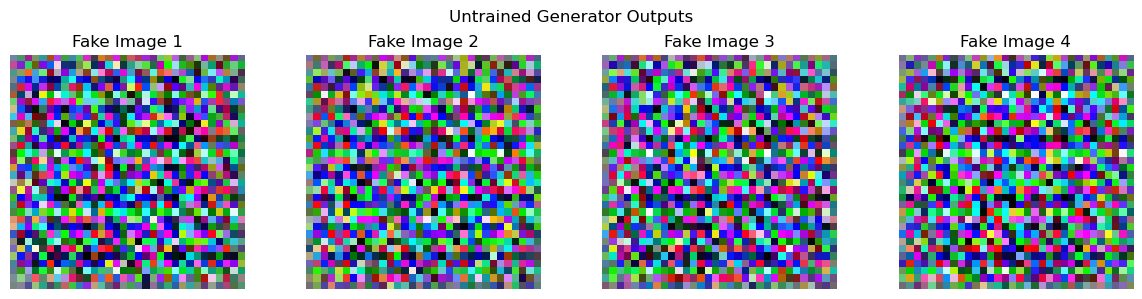

In [6]:
# Generate 4 fake images
with torch.no_grad():
    noise_sample = torch.randn(4, 100).to(device)
    generated_images = generator(noise_sample)

# Denormalize from [-1, 1] to [0, 1]
generated_images = (generated_images.cpu() + 1) / 2

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = generated_images[i].permute(1, 2, 0).numpy()
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].axis("off")
    axes[i].set_title(f"Fake Image {i+1}")

plt.suptitle("Untrained Generator Outputs")
plt.tight_layout()
plt.show()

## ✅ Key Takeaways

- The **Generator** maps noise → image.
- The **Discriminator** learns to distinguish real vs. fake.
- They are trained in **adversarial alternation**.
- Even without full training, the architecture shows how deepfakes are created.

> 🔜 Next: We'll train a real DCGAN on cifar10 / CelebA dataset!